In [22]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import logger_creator

import graph_tools
import networkx as nx
import numpy as np
import pandas as pd

# Create and Explore Graph

In [23]:
df = pd.read_csv(
    "../datasets/slashdot_zoo.matrix",
    sep=r"\s+",
    comment="%",
    header=None,
    names=["source", "target", "weight"]
)
df_clean = df[df['weight'] > 0]

print("Number of edges before cleaning:", len(df))
print("After:", len(df_clean))

slashdot_zoo_graph = nx.from_pandas_edgelist(
    df_clean,
    source="source",
    target="target",
    create_using=nx.DiGraph,
    edge_attr="weight",
)

Number of edges before cleaning: 515397
After: 392179


In [24]:
len(slashdot_zoo_graph)

69995

In [9]:
slashdot_zoo_graph_prepared = graph_tools.prepare_graph(slashdot_zoo_graph.nodes(), slashdot_zoo_graph.edges(), sink_frac=0.0)
nodes = slashdot_zoo_graph_prepared.nodes()
delegations_orig = graph_tools.nx_graph_to_dict(slashdot_zoo_graph_prepared)
delegations = graph_tools.invert_graph(delegations_orig)

2025-06-25 10:57:27,781 - INFO - Initially 69995 nodes, after collapsing terminal SCCs 68934 nodes remain. In total 498 terminal SCCs were collapsed.


In [28]:
removed_nodes = 69995 - 68934
amount_of_clos_deg_cycles = 498
print("Number of removed nodes:", removed_nodes)
print("Average number of nodes per closed delegation cycle:", removed_nodes / amount_of_clos_deg_cycles)

Number of removed nodes: 1061
Average number of nodes per closed delegation cycle: 2.1305220883534135


Number of nodes:  68934
Outdegree:


count    68934.000000
mean         5.663026
std         19.453540
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        424.000000
Name: outdegree, dtype: float64

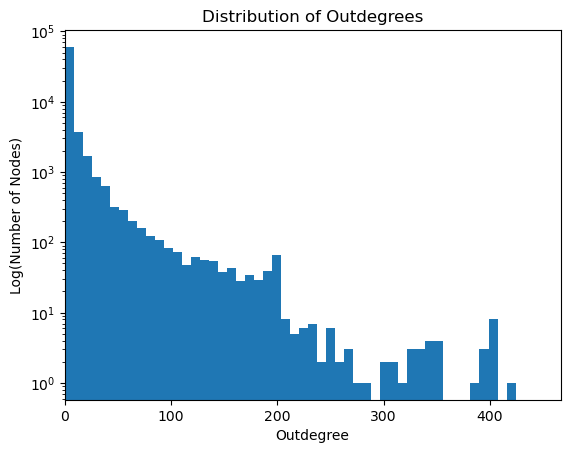

In [26]:
print("Number of nodes: ", len(slashdot_zoo_graph_prepared))

outdegrees = pd.DataFrame(slashdot_zoo_graph_prepared.out_degree(), columns=["node", "outdegree"])
print("Outdegree:")
display(outdegrees['outdegree'].describe())

plt.figure()
plt.hist(outdegrees['outdegree'], bins=50)
plt.xlabel('Outdegree')
plt.ylabel('Log(Number of Nodes)')
plt.title('Distribution of Outdegrees')
plt.yscale('log')
plt.xlim(0, outdegrees['outdegree'].max() * 1.1) 
plt.show()

In [27]:
sinks = [node for node in nodes if len(delegations_orig[node]) == 0]
print("Number of sinks:", len(sinks))
print("Total number of nodes:", len(nodes))
print("Fraction of sinks:", len(sinks) / len(nodes))

Number of sinks: 28709
Total number of nodes: 68934
Fraction of sinks: 0.41647082716801576


# Resolve and Explore Powers

In [ ]:
powers, sinks = le.resolve_delegations(delegations, nodes)


In [ ]:
powers_df = pd.DataFrame.from_dict(powers, orient="index", columns=["power"])
powers_df.describe()

In [ ]:
display(powers_df.sort_values(by="power", ascending=False))

In [ ]:
print("Number of sinks:", len(sinks))
print("Total number of nodes:", len(nodes))
print("Fraction of sinks:", len(sinks) / len(nodes))

In [ ]:
plt.hist(powers_df['power'], bins=50)
plt.xlabel('Power')
plt.ylabel('Number of Nodes')
plt.title('Histogram of Node Powers')
plt.yscale('log')
plt.show()

# Benchmark

In [19]:
logger, handler = logger_creator.create_logger("benchmarking")

# Verify the solutions are equal
powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
powers_iter = iterative.iterate_delegations(delegations, nodes)

if powers_le.keys() != powers_lp.keys():
    logger.error("Key mismatch between LE and LP powers.")
    print("Mismatching powers in LE and LP. Check the log file for details.")
else:
    mismatches = []
    for k in powers_le:
        diff = abs(powers_le[k] - powers_lp[k])
        if diff > 10**4:
            mismatches.append((k, powers_le[k], powers_lp[k], diff))
    
    if mismatches:
        logger.error("Power values do not match between LE and LP.")
        for k, le_power, lp_power, diff in mismatches:
            logger.error(f"Node {k}: LE={le_power:.6f}, LP={lp_power:.6f}, Diff={diff:.6f}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
    
mismatches = []
for node in nodes:
    diff = abs(powers_lp[node] - powers_iter[node])
    if diff >= 0.01:
        mismatches.append((node, powers_lp[node], powers_iter[node], diff))

if mismatches:
    logger.error("Powers do not match.")
    for node, lp_power, iter_power, diff in mismatches:
        logger.error(f"Node {node}: LP={lp_power:.4f}, Iterative={iter_power:.4f}, Diff={diff:.4f}")
    print("Mismatching powers in LP and Iterative. Check the log file for details.")
else:
    print("All powers match within tolerance.")

n = 2

# LE
le_model = le.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    le.solve(*le_model)
end_time = time.time()
        
time_le = (end_time - start_time) / n

# LP
lp_model = lp.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    lp.solve(*lp_model)
end_time = time.time()

time_lp = (end_time - start_time) / n

# Iterative
start_time = time.time()
for _ in range(n):
    p = iterative.iterate_delegations(delegations, nodes)
end_time = time.time()

time_iterative = (end_time - start_time) / n


logger.removeHandler(handler)
handler.close()


All powers match within tolerance.


In [21]:
print("Time LE:", time_le)
print("Time LP:", time_lp)
print("Time Iterative:", time_iterative)

Time LE: 246.70037293434143
Time LP: 380.31449699401855
Time Iterative: 26.939793586730957


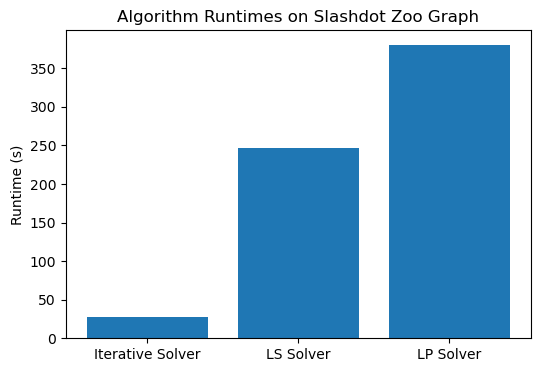

In [20]:
plt.figure(figsize=(6,4))
plt.bar(["Iterative Solver", "LS Solver", "LP Solver"], [time_iterative, time_le, time_lp])
plt.ylabel("Runtime (s)")
plt.title("Algorithm Runtimes on Slashdot Zoo Graph")
plt.show()